## Objective
Revamp templates.ipynb by including waveforms on surrounding electrodes
(Next steps after 4/17/23 MEA meeting)

Investigate units on each end of U-Shape agreement score distribution

In [96]:
# region Set up notebook imports
%load_ext autoreload
%autoreload 2
# Allow for imports of other scripts
import sys
PATH = "/data/MEAprojects/PropSignal"
if PATH not in sys.path:
    sys.path.append(PATH)
# Reload a module after changes have been made
from importlib import reload
# endregion

import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import sys
from pathlib import Path
from tqdm import tqdm

from src import utils
from src.recording import Recording
from src.sorters.prop_signal import PropSignal
from src.sorters.kilosort import get_experts_kilosort
from src.comparison import Comparison

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
recording = utils.rec_si()
RMS = utils.chans_rms_si()

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


Recording does not have scaled traces. Setting gain to 0.195


In [98]:
prop_signal = PropSignal("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230728", recording)
spikes_prop = prop_signal.get_spike_times()

In [171]:
recording.get_channel_locations()[40:]

array([[  59.,  440.],
       [  27.,  440.],
       [  43.,  460.],
       [  11.,  460.],
       [  59.,  480.],
       [  27.,  480.],
       [  43.,  500.],
       [  11.,  500.],
       [  59.,  520.],
       [  27.,  520.],
       [  43.,  540.],
       [  11.,  540.],
       [  59.,  560.],
       [  27.,  560.],
       [  43.,  580.],
       [  11.,  580.],
       [  59.,  600.],
       [  27.,  600.],
       [  43.,  620.],
       [  11.,  620.],
       [  27.,  840.],
       [  59.,  880.],
       [  43.,  900.],
       [  11.,  900.],
       [  59.,  920.],
       [  27.,  920.],
       [  43.,  940.],
       [  11.,  940.],
       [  59.,  960.],
       [  27.,  960.],
       [  43.,  980.],
       [  11.,  980.],
       [  59., 1000.],
       [  27., 1000.],
       [  43., 1020.],
       [  11., 1020.],
       [  59., 1040.],
       [  27., 1040.],
       [  43., 1060.],
       [  11., 1060.],
       [  59., 1080.],
       [  27., 1080.],
       [  43., 1100.],
       [  1

In [ ]:
kilosort = get_experts_kilosort()
spikes_ks = kilosort.get_spike_times()

Num Prop.: 89
Num Experts Kilosort: 226
Num single matches: 56

For Prop.:
Num max matches: 59
Num unique max matches: 47

For Experts Kilosort:
Num max matches: 83
Num unique max matches: 48


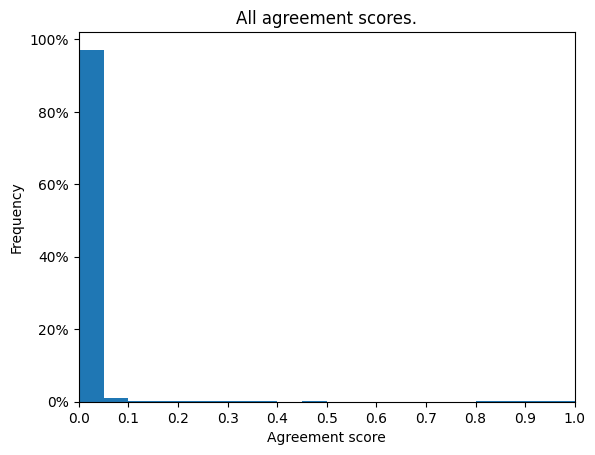

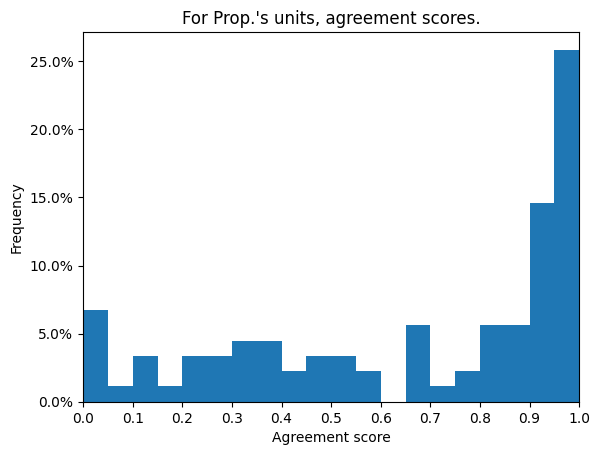

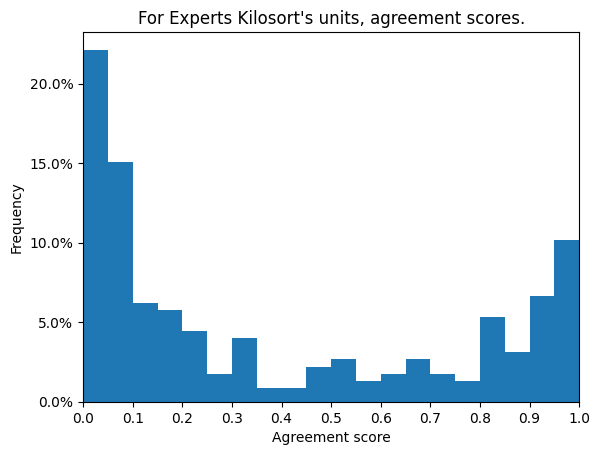

In [ ]:
comparison = Comparison(prop_signal, kilosort, score_formula=2)
comparison.summary()

In [153]:
class Match:
    def __init__(self, idx_prop, idx_ks):
        self.idx_prop = idx_prop
        self.idx_ks = idx_ks

        self.st_prop = spikes_prop[idx_prop]
        self.prop = prop_signal.props[idx_prop]

        self.st_ks = spikes_ks[idx_ks]
        self.score = comparison.agreement_scores[idx_prop, idx_ks]

        self.save_name = f"{self.score*100:.0f}_{idx_ks}"

    def get_matching_spikes(self, delta=0.4):
        times1 = self.st_prop
        times2 = self.st_ks

        matched = []
        unmatched1 = []

        already_matched = set()
        for st1 in times1:
            idx = np.searchsorted(times2, st1)
            idx_left = idx - 1
            while idx_left in already_matched:
                idx_left -= 1
            if idx_left >= 0:
                left = times2[idx_left]
            else:
                left = -np.inf

            idx_right = idx
            while idx_right in already_matched:
                idx_right += 1
            if idx_right < len(times2):
                right = times2[idx_right]
            else:
                right = np.inf

            if right - st1 < st1 - left:
                if right - st1 <= delta:
                    matched.append(st1)
                    already_matched.add(idx_right)
                else:
                    unmatched1.append(st1)
            else:
                if st1 - left <= delta:
                    matched.append(st1)
                    already_matched.add(idx_left)
                else:
                    unmatched1.append(st1)

        unmatched2 = [times2[i] for i in range(len(times2)) if i not in already_matched]

        return matched, unmatched1, unmatched2

    def extract_waveforms(self, spike_times, max_spikes=300):
        wfs = np.zeros((len(spike_times), N_CHANS, N_BEFORE + 1 + N_AFTER), dtype="float32")
        if len(spike_times) == 0 :
            return wfs

        if len(spike_times) > max_spikes:
            spike_times = np.array(spike_times)[np.random.choice(len(spike_times), size=max_spikes, replace=False)]

        wfs = np.zeros((len(spike_times), N_CHANS, N_BEFORE + 1 + N_AFTER), dtype="float32")
        for i, st in enumerate(spike_times):
            st = int(st * SF)
            traces = recording.get_traces_filt(st-N_BEFORE, st+N_AFTER+1)
            if traces.shape[1] == wfs.shape[2]:
                wfs[i, :, :] = traces
            else:
                if st-N_BEFORE < 0:
                    wfs[i, :, :traces.shape[1]] = traces
                else:
                    wfs[i, :, -traces.shape[1]:] = traces
        return wfs

    def plot(self, save=False):
        SUBPLOTS_NAMES = (f"Matched waveforms", "Prop waveforms", "Kilosort waveforms")

        MAX_WAVEFORMS = 200  # Maximum number of waveforms to plot for a channel

        WINDOW_HALF_SIZE = 90  # length and width of window will be WINDOW_HALF_SIZE * 2
        # SCALE_H = 0.1 # Multiple height of waveform by this to scale it down

        CMAP = plt.get_cmap("viridis")

        MAX_DOT_SIZE = 55  # For marking which channels are in prop unit
        MARKERS = "oXDs*pP1267" # For distinguishing between props in a merge
        
        matching_spikes = self.get_matching_spikes()  # matched, unmatched_prop, unmatched_ks
        matching_waveforms = [self.extract_waveforms(spikes) for spikes in matching_spikes]
    
        fig, subplots = plt.subplots(1, 3, figsize=(9, 6), tight_layout=True)
        fig.suptitle(f"Prop: {self.idx_prop}|{len(self.st_prop)}. "
                     f"Kilosort: {self.idx_ks}|{len(self.st_ks)}. "
                     f"Score: {self.score:.3f}")

        chan_center = self.prop[0].ID[0]

        max_amp = -np.inf
        for wfs in matching_waveforms:
            templates = np.mean(wfs, axis=0)
            amp = np.max(np.abs(templates[max(0, chan_center-5):chan_center+5]))
            max_amp = max(max_amp, amp)
        SCALE_H = 20 / max_amp

        for axis, axis_name, waveforms in zip(subplots, SUBPLOTS_NAMES, matching_waveforms):
            templates = np.mean(waveforms, axis=0)

            # If waveforms is empty
            if waveforms.size == 0: continue

            # waveforms = waveforms[:, self.prop[0].ID[0], :]
            # template = np.mean(waveforms, axis=0)
            # a.plot(waveforms.T, c="#aaaaaa", alpha=0.5)
            # a.plot(template, c="black")

            axis.set_title(axis_name)
            axis.set_aspect("equal")
            axis.set_xlabel("x (μm)")
            axis.set_ylabel("y (μm)")

            chans, dists = nearest_chan[chan_center]
            loc_center = locs[chan_center]
            max_dist = np.sqrt(2) * WINDOW_HALF_SIZE  # Distance from center of window to corner

            axis.set_xlim(2, 68)  # 11, 59
            axis.set_ylim(loc_center[1]-WINDOW_HALF_SIZE, loc_center[1]+WINDOW_HALF_SIZE)

            scale = lambda y: y * SCALE_H + loc[1]

            # Plot each channel waveform
            for c in chans:
                loc = locs[c]
                if np.sqrt(np.sum(np.square(loc - loc_center))) >= max_dist:
                    break
                x_values = np.linspace(loc[0]-7, loc[0]+7, waveforms.shape[2])

                # Plot individual waveforms
                for w, wf in enumerate(waveforms[:, c, :]):
                    if w == MAX_WAVEFORMS: break
                    axis.plot(x_values, scale(wf), c="#dddddd", alpha=0.02)

                # Plot template
                temp = templates[c, :]
                # axis.plot(x_values, y_values, c="red" if c == chan_center else "black")
                axis.plot(x_values, scale(temp), "black", zorder=12)

                # Plot 5RMS
                axis.plot(x_values, [scale(-RMS[c]*5)] * len(x_values), c="red", alpha=0.8)

            # Mark which electrodes are in the prop signal
            for i, prop in enumerate(self.prop):  # Could be multiple because of merging
                locs_prop = locs[prop.ID.values] - 4
                locs_prop[:, 1] -= 4 * i  # Multiple dots for merged propagations
                latencies = prop.latency.values
                sizes = prop.small_window_cooccurrences.values
                sizes *= MAX_DOT_SIZE/np.max(sizes)
                scatter = axis.scatter(locs_prop[:, 0], locs_prop[:, 1], c=latencies, s=sizes, zorder=10, cmap=CMAP,
                                       marker=MARKERS[i])

                # Mark which dot is the first electrode
                axis.scatter(*locs_prop[0, :], color="black", s=sizes[0], zorder=12, cmap=CMAP, marker=MARKERS[i])

        plt.colorbar(scatter, label="Latency (ms)", location="right", ax=axis)

        if not save:
            plt.show()
        else:
            plt.savefig(SAVE_PATH_PLOTS / f"{self.save_name}.png")
            plt.close(fig)

In [156]:
"""
Create matches
"""
matches = []
SAVE_PATH_PLOTS = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230728/max_ks_to_prop")

spikes_prop = prop_signal.get_spike_times()
spikes_ks = kilosort.get_spike_times()
for idx_ks in range(len(spikes_ks)):
    scores = comparison.agreement_scores[:, idx_ks]
    matches.append(Match(np.argmax(scores), idx_ks))

matches_sorted = sorted(matches, key=lambda m: m.score)
# for i, match in enumerate(matches_sorted):
#     print(i)
#     match.plot()
    
#     temps = kilosort[match.idx_ks].get_templates()
#     print(recording.get_channel_locations()[np.argmin(np.min(temps, axis=1))])
#     for e, temp in enumerate(temps):
#         plt.plot(temp / RMS[e])
#     plt.show()

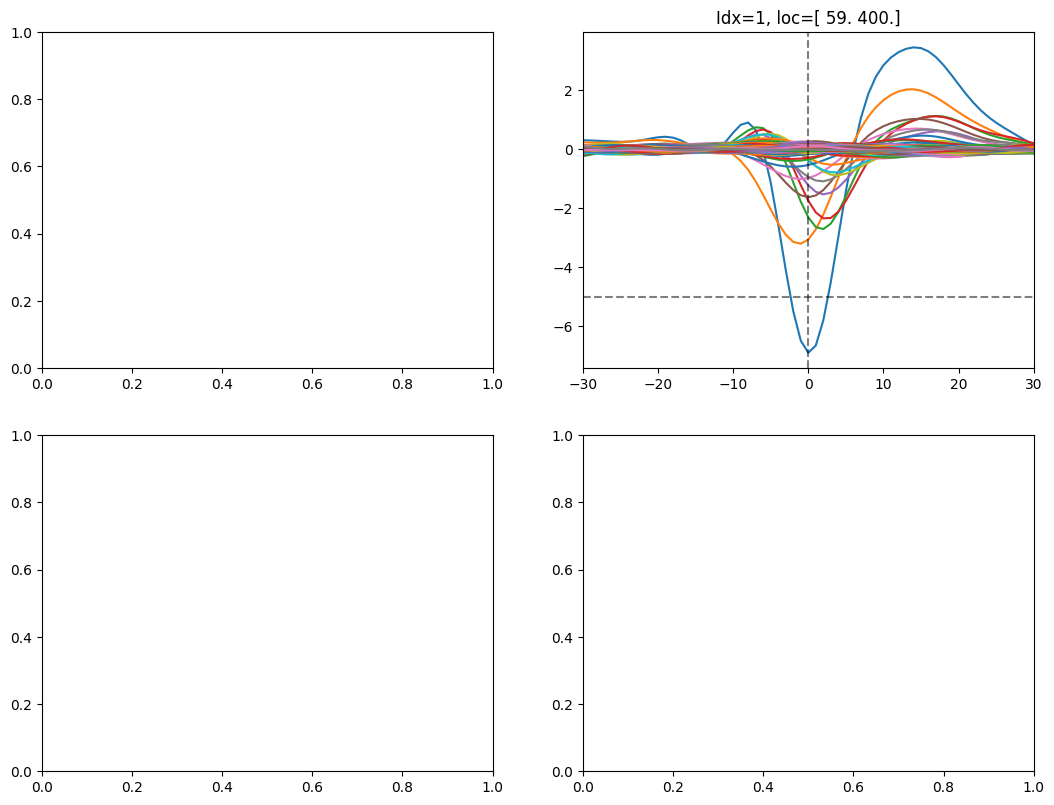

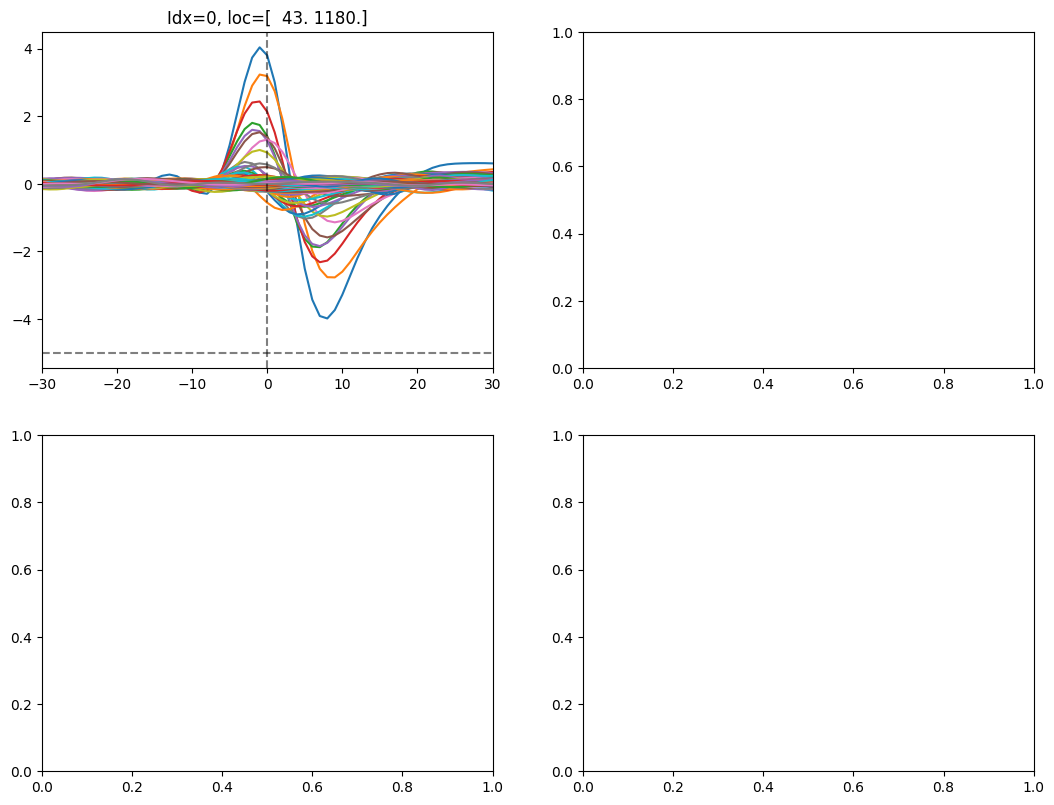

In [167]:
N_ROWS = 2
N_COLS = 2

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(6.4*N_COLS, 4.8*N_ROWS))

chan_locs = recording.get_channel_locations()
# for k in range(len(kilosort)):
for k in [45, 80]:
    if k % (N_ROWS * N_COLS) == 0 and k > 0:
        plt.show()
        fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(6.4*N_COLS, 4.8*N_ROWS))

    temps = kilosort[k].get_templates(ms_before=1, ms_after=1)

    k %= N_COLS * N_ROWS
    col = k % N_COLS
    row = k // N_COLS
    
    loc = chan_locs[np.argmin(np.min(temps, axis=1))]
    
    chans = np.argsort(np.min(temps, axis=1))
    x_values = np.arange(temps.shape[1]) - temps.shape[1]//2
    for c in chans:
        axes[row, col].plot(x_values, temps[c] / RMS[c])
    axes[row, col].axhline(-5, color="black", alpha=0.5, linestyle="dashed")
    axes[row, col].axvline(0, color="black", alpha=0.5, linestyle="dashed")
    
    axes[row, col].set_title(f"Idx={k}, loc={loc}")
    axes[row, col].set_xlim(x_values[0], x_values[-1])

plt.show()
    

## Plot

In [141]:
N_BEFORE = int(2 * recording.get_sampling_frequency())
N_AFTER = int(2 * recording.get_sampling_frequency())
N_CHANS = len(recording.get_channel_locations())
SF = recording.get_sampling_frequency()

In [142]:
"""
If i is the index of a channel, then the ith element of self.nearest_chan is a tuple
    0) Closest channels indices: An where the 0th element is i, 1st element is closest channel, 2nd element is second closest channel, etc.
    1) Distance of channels
"""
nearest_chan = []
locs = recording.get_channel_locations()
# locs[:, 0] *= 1.5
for i in range(len(locs)):
    loc = locs[i]
    dists = np.sqrt(np.sum(np.square(locs - loc), axis=1))
    dists_sorted = np.sort(dists)
    chans_sorted = np.argsort(dists)

    nearest_chan.append((chans_sorted, dists_sorted))

In [157]:
# Create the plots
def job_match(idx):
    match = matches_sorted[idx]
    match.plot(save=True)

with Pool(processes=12) as pool:
    tasks = range(len(matches_sorted))
    for _ in tqdm(pool.imap(job_match, tasks), total=len(tasks)):
        pass

100%|██████████| 226/226 [10:36<00:00,  2.82s/it]


#### Move template plots from individual folders of each unit so folder with all plots

In [ ]:
import shutil
from pathlib import Path

In [ ]:
ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230728/max_ks_to_prop")
DEST = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230728/max_ks_to_prop/templates_spatial_plots")
#
for unit_folder in ROOT.iterdir():
    unit_plot = unit_folder / "templates_spatial.png"
    if unit_plot.exists():
        name = unit_folder.name + ".png"
        shutil.copy(unit_plot, DEST / name)